# Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

In [2]:
filename = 'train.csv'

First of all we read the file leaving apart unnecessary columns with non-grouppable unique values.

In [3]:
df = pd.read_csv(filename).drop(['Ticket', 'PassengerId', 'Cabin'], axis = 1)

In [4]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


# Cleaning

First of all lets get rid of the two entries with the absent information about embarkment.

In [6]:
df=df[df['Embarked'].notnull()].reset_index(drop=True)

After that we create the binary variable indicating whether the passanger has a family. Obvoiusly, this creates some data redundancy, but it will be leveled by the ML tools afterwards.

In [7]:
df['Family'] = (df['SibSp'] + df['Parch'] > 0).astype(int)

Also lets make the binary Sex variable numerical.

In [8]:
df['Sex'] = df['Sex'].replace('female', 0).replace('male', 1)

The next section fills the entries with the absent age with the median age for the group with of same sex and passanger class as the one of the entry.

In [9]:
age_median = df.groupby(['Sex','Pclass'])['Age'].median()

In [10]:
def age_estimator(entry):
    if pd.isnull(entry['Age']):
        return age_median[entry['Sex'],entry['Pclass']]
    return entry['Age']

In [11]:
df['Age'] = df.apply(age_estimator, axis=1)

Also, lets extract the prefix from the names.

In [12]:
def prefix(x):
    if 'Mrs.' in str(x):
        return 'Mrs.'
    elif 'Mr.' in str(x):
        return 'Mr.'
    elif 'Miss.' in str(x):
        return 'Miss.'
    elif 'Master.' in str(x):
        return 'Master.'
    elif 'Dr.' in str(x):
        return 'Dr.'
    return 'Other'

In [13]:
df['Prefix']=[prefix(i) for i in df['Name']]

In [14]:
del df['Name']

Then lets create dummy columns for the values of both categorical columns.

In [15]:
for categorical_column in ['Embarked', 'Prefix']:
    for i in df[categorical_column].unique():
        df['{}_{}'.format(categorical_column, i)] = [int(j == i) for j in df[categorical_column]]

In [16]:
del df['Embarked']
del df['Prefix']

In [17]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family,Embarked_S,Embarked_C,Embarked_Q,Prefix_Mr.,Prefix_Mrs.,Prefix_Miss.,Prefix_Master.,Prefix_Other,Prefix_Dr.
0,0,3,1,22.0,1,0,7.2500,1,1,0,0,1,0,0,0,0,0
1,1,1,0,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,1,0,0,0,0,1,0,0,0
3,1,1,0,35.0,1,0,53.1000,1,1,0,0,0,1,0,0,0,0
4,0,3,1,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 17 columns):
Survived          889 non-null int64
Pclass            889 non-null int64
Sex               889 non-null int64
Age               889 non-null float64
SibSp             889 non-null int64
Parch             889 non-null int64
Fare              889 non-null float64
Family            889 non-null int64
Embarked_S        889 non-null int64
Embarked_C        889 non-null int64
Embarked_Q        889 non-null int64
Prefix_Mr.        889 non-null int64
Prefix_Mrs.       889 non-null int64
Prefix_Miss.      889 non-null int64
Prefix_Master.    889 non-null int64
Prefix_Other      889 non-null int64
Prefix_Dr.        889 non-null int64
dtypes: float64(2), int64(15)
memory usage: 118.1 KB


Voi la! The cleaning is finished. We have 889 entries with purely numerical values.

# Preliminary Feature Importance Tests

For the further ML stage lets make the target values array and three different feature sets. As our purpose is to identify the effect of having family on survival, one feature set is complete, while the other contains no family-related variables and the last consists only of the family-related ones.

In [19]:
y = np.array(df['Survived'])
X = df.loc[:, ~df.columns.isin(['Survived'])]
X_ = df.loc[:, ~df.columns.isin(['Survived', 'SibSp', 'Parch', 'Family'])]
_X_ = df[[ 'SibSp', 'Parch', 'Family']]

## Exploratory Analysis

For the purpose of the visual friendliness for this part only lets return tha names of genders as well as the booleans for the family.

In [20]:
df['Sex'] = df['Sex'].replace(0, 'Female').replace(1, 'Male')
df['Family'] = df['Family'].astype('bool')

Then lets visually explore the survival rate and overall number of passanger for both genders, all three classes and, what is the most importans for us, the presence of family.

In [21]:
mean_exp = pd.DataFrame(df.groupby(['Pclass', 'Sex', 'Family'])['Survived'].mean())
mean_exp.reset_index(inplace=True)  
mean_exp.rename(columns={'Survived':'Survival Rate'}, inplace=True)

In [22]:
count_exp = pd.DataFrame(df.groupby(['Pclass', 'Sex', 'Family'])['Survived'].count())
count_exp.reset_index(inplace=True)
count_exp.rename(columns={'Survived':'Count'}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


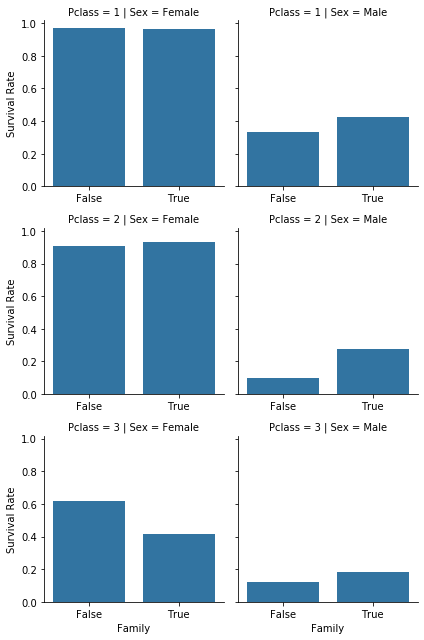

In [23]:
g = sns.FacetGrid(mean_exp, row="Pclass", col="Sex", sharex=False)
g.map(sns.barplot, 'Family', 'Survival Rate')
plt.show()

As we can see, in the first two calsses the vast majority of women survived independently on the family status. In contrast, the third class women had higher probability to survive if they did not have family. This may ba caused by the fact that the ones with family sank trying to save their children at the bottom-level cabins instead of fighting for lifeboats. 

In all the classes men with family had higher chance to survive. This may be caused by the fact that they had higher priority for the lifeboats due to the need to join the family.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


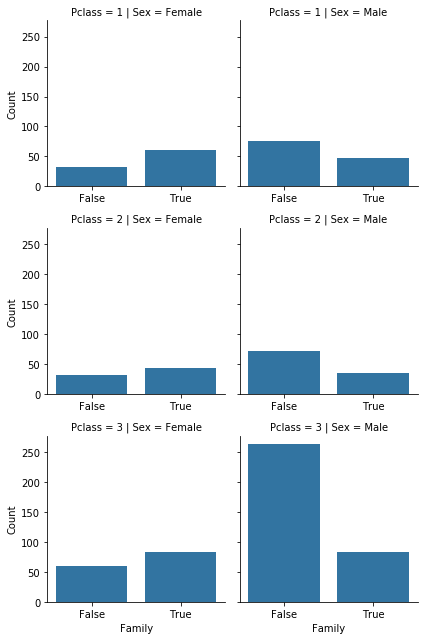

In [24]:
g = sns.FacetGrid(count_exp, row="Pclass", col="Sex", sharex=False)
g.map(sns.barplot, 'Family', 'Count')
plt.show()

As for the absolute numbers, in all three classes women were more likely to have family, while most males were single and with no children at the boat. Also we can see that the majority of passangers were the third class ones, especially the no-family males.

In [25]:
df['Sex'] = df['Sex'].replace('Female', 0).replace('Male', 1)
df['Family'] = df['Family'].astype('int')

## Correlation Matrix

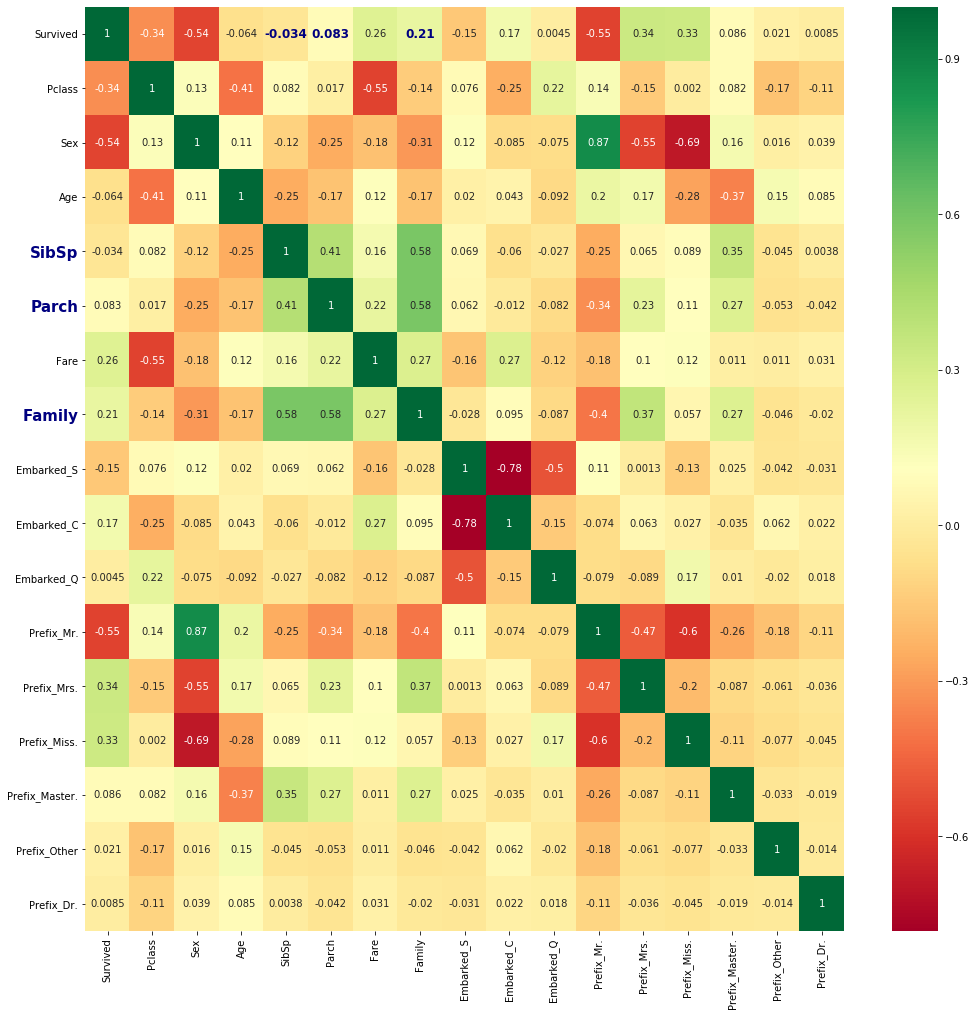

In [26]:
plt.figure(figsize=(len(df.columns),len(df.columns)))
ax=sns.heatmap(df[df.corr().index].corr(),annot=True,cmap="RdYlGn")
for lab, annot in zip(ax.get_yticklabels(), ax.texts):
    text =  lab.get_text()
    if text in ['SibSp', 'Parch', 'Family']:
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('navy')
        annot.set_weight('bold')
        annot.set_color('navy')
        annot.set_size(12)

From the overall correlation matrix we may clearly see that despite the fact that both "SibSp" and "Parch" have different signs and quite low absolute values, the "Family" has a more significant positive correlation with survival. Not as significant as Fare or Sex, but still.

## Chi^2 Test

In [27]:
best_scores_chi2 = SelectKBest(score_func=chi2, k=len(X.columns)).fit(X,y).scores_
importance = pd.DataFrame(best_scores_chi2, columns=['Importance'],index=X.columns)
importance.sort_values(by=['Importance'], ascending=False, inplace=True)
importance.style.apply(lambda x: ['background: lightgreen' if x.name in ['SibSp', 'Parch', 'Family'] else '' for i in x], 
               axis=1)

,Importance
Fare,4453.39
Prefix_Mr.,111.586
Sex,91.514
Prefix_Mrs.,87.341
Prefix_Miss.,75.4059
Pclass,30.1353
Family,22.7489
Age,22.3207
Embarked_C,20.8286
Parch,10.4486


The Chi2 test also leads to a similar conclusion about the importance family-related features.

## Random Forest Feature Importance

In [28]:
best_scores_forest = RandomForestClassifier(n_estimators=100, max_depth=None).fit(X, y).feature_importances_
importance = pd.DataFrame(best_scores_forest, columns=['Importance'],index=X.columns)
importance.sort_values(by=['Importance'], ascending=False, inplace=True)
importance.style.apply(lambda x: ['background: lightgreen' if x.name in ['SibSp', 'Parch', 'Family'] else '' for i in x], 
               axis=1)

,Importance
Fare,0.243056
Age,0.227615
Prefix_Mr.,0.139247
Sex,0.119499
Pclass,0.0768937
SibSp,0.0466642
Prefix_Mrs.,0.0302712
Parch,0.0288412
Prefix_Miss.,0.0227785
Family,0.0135968


The Random Forest classifier also indicates the average importance of family-related features. Due to the logics of random forest and the fact that the value of "Family" is derived from the values of two primary family-related features, it is not surprising that "Family" is considered the least important out of the three.

# Prediction

In this section we prove that the presence of family affects the survival probability. To do this we estimate the accuracy of various ML models with the survival as the target variable and three different possible feature matrices: the full one, the one without family-related features and the one with family-related features only.

If our assumption (the presence of family affects the survival probability but is not among the most significant factors) is correct, the following results should appear in the majority of models:

1) The score for the model using only family-related features should be better than the baseline.

2) The score for the full model should be slightly higher than for the one without family-related features.

Lets check.

First of all, as the majority of passanger did not survive, the baseline accuracy is the one which appears if we label all the cases as non-survived.

In [29]:
print('The mode is {}.'.format(int(stats.mode(y)[0])))
baseline = 1 - y.sum()/len(y)
print('Therefore the baseline accuracy score is {}.'.format(baseline))

The mode is 0.
Therefore the baseline accuracy score is 0.6175478065241844.


In [30]:
def grid_classify(classifier, param):
    grid = GridSearchCV(estimator = classifier, param_grid = param, scoring = 'accuracy', cv = 10)
    
    grid_full = grid.fit(X, y)
    accuracy_full = grid_full.best_score_
    param_full = grid_full.best_params_
    
    
    grid_no_family = grid.fit(X_, y)
    accuracy_no_family = grid_no_family.best_score_
    param_no_family = grid_no_family.best_params_
    
    grid_family = grid.fit(_X_, y)
    accuracy_family = grid_family.best_score_
    param_family = grid_family.best_params_
    
    print('The best score for full data is\n{}\nwith the following parameters:\n{}'.format(accuracy_full, 
                                                                                    param_full))
    print()
    print('The best score without family is\n{}\nwith the following parameters:\n{}'.format(accuracy_no_family,
                                                                                     param_no_family))
    
    print()
    print('The best score for only family is\n{}\nwith the following parameters:\n{}'.format(accuracy_family,
                                                                                     param_family))
    pass

For the purepose of clean experiment we use cross-validation and grid parameter calibration for each of three cases individually.

## Logistic Regression

In [31]:
log_reg = LogisticRegression(max_iter = 1000, solver = 'liblinear', random_state = 0)
param_logreg = [{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1','l2']}]
grid_classify(log_reg, param_logreg)

The best score for full data is
0.829021372328459
with the following parameters:
{'C': 10, 'penalty': 'l2'}

The best score without family is
0.7997750281214848
with the following parameters:
{'C': 100, 'penalty': 'l1'}

The best score for only family is
0.6636670416197975
with the following parameters:
{'C': 1, 'penalty': 'l1'}


## Desicion Tree

In [32]:
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
param_tree = [{'max_depth' : [None, 1, 3, 5, 7, 9], 
               'min_samples_split': [5, 10, 15, 20, 25, 30], 
               'min_samples_leaf': [1, 2, 3, 4, 5], 
               'max_features': ['auto', 'log2']}]

In [33]:
grid_classify(tree, param_tree)

The best score for full data is
0.8278965129358831
with the following parameters:
{'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15}

The best score without family is
0.8211473565804275
with the following parameters:
{'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}

The best score for only family is
0.6760404949381328
with the following parameters:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15}


## Random Forest

In [34]:
forest = RandomForestClassifier(random_state = 0)
param_forest = [{'n_estimators': [100, 200, 300], 
                 'max_depth': [3, 5, 7, 9], 
                 'min_samples_split': [2, 4, 6]}]

In [35]:
grid_classify(forest, param_forest)

The best score for full data is
0.8335208098987626
with the following parameters:
{'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 200}

The best score without family is
0.8368953880764904
with the following parameters:
{'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 200}

The best score for only family is
0.6782902137232846
with the following parameters:
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


As we can see, this is the case where the accuracy whithout family is the highest. This happens in about half of the cases dependent on the random state.

## SGClassifier

In [36]:
sgd = SGDClassifier(max_iter=1000, penalty = 'elasticnet', random_state = 0)
param_sgd = [{'alpha' : [.00001, .0001, .001], 
              'l1_ratio' : [0, .2, .5, .8, 1], 
              'max_iter':[100, 1000]}]

In [37]:
grid_classify(sgd, param_sgd)

The best score for full data is
0.7896512935883014
with the following parameters:
{'alpha': 0.0001, 'l1_ratio': 0.8, 'max_iter': 100}

The best score without family is
0.7862767154105736
with the following parameters:
{'alpha': 0.001, 'l1_ratio': 1, 'max_iter': 100}

The best score for only family is
0.6636670416197975
with the following parameters:
{'alpha': 0.001, 'l1_ratio': 0.2, 'max_iter': 100}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Gradient Boosting 

In [38]:
g_boost = GradientBoostingClassifier(random_state = 0)
param_g_boost = [{'min_samples_split': [5, 10, 15, 20, 25, 30], 
                  'min_samples_leaf': [1, 2, 3, 4, 5], 
                  'max_features': ['auto', 'log2']}]

In [39]:
grid_classify(g_boost, param_g_boost)

The best score for full data is
0.8391451068616423
with the following parameters:
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 25}

The best score without family is
0.8357705286839145
with the following parameters:
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 20}

The best score for only family is
0.6782902137232846
with the following parameters:
{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15}


Yes, the majority listed models prove our hypothesis!

# Conclusion

Overall, we see that the presence of family ceteris paribus increase the survival chance. The information about the family status has certain significance, however not the highest, and in the majority of models brings extra explanatory power to the other features.

Limitations: the deeper analysis may require the exploratory analysis of the relations between various family-related features (not only "Family") with multiple other features (not only "Class" and "Sex"). Also, other ML models such as SVM or Neural Networks could be used to further prove the assumption. However, as нет пределов совершенству, it seems that the analysis above is enough as a proof of the mentioned hypothesis.